# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'data': {
        'd': 2, #degree
        'n': 5, #number of variables
        'monomial_vars': None, #int or None
        'laurent': False, #use Laurent polynomials (negative degree with up to -d)  
        'neg_d': 0,#int or None
        'neg_d_prob': 0,
        'sparsity': None,
        'sample_sparsity': 5,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 10000,
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'border_min': 0.2, #needs to be between 0 and (x_max-x_min)/2
        'border_max': 0.4,
        'lower_degree_prob': 0.5,
        'a_zero_prob': 0.25,
        'a_random_prob': 0.1,      
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sample_sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'dropout_output': 0,
        'epochs': 1, 
        'early_stopping': True,
        'batch_size': 256,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 100,
                
        'interpretation_net_output_monomials': 5, #(None, int) #CONSTANT IS NOT INCLUDED
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 10, #Float for fraction, Int for number 0
        
        'normalize_inet_data': False,
        'inet_training_without_noise': False, #dataset size without noise hardcoded to 50k in generate_paths
        'sparse_poly_representation_version': 2, #(1, 2); 1=old, 2=new

        'evaluate_with_real_function': True, #False
        'consider_labels_training': True, #False
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
        
        'symbolic_metamodeling_evaluation': False,
        'symbolic_metamodeling_poly_evaluation': False,
        'symbolic_metamodeling_function_evaluation': False,
        'symbolic_metamodeling_poly_function_evaluation': False,
        
        'symbolic_regression_evaluation': True,
        'per_network_evaluation': False,
    },
    'computation':{
        'n_jobs': 10,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex, clear_output



In [4]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [5]:
from utilities.utility_functions import flatten, rec_gen

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    if len(list_of_monomial_identifiers_extended) < 500:
        print(list_of_monomial_identifiers_extended)        
else:
    variable_sets = [[_d for _d in range(d+1)] for _ in range(n)]  
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)

    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity: ' + str(sparsity))
    if len(list_of_monomial_identifiers_extended) < 500:
        print(list_of_monomial_identifiers_extended)    
list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    if np.sum(monomial_identifier) <= d:
        if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
            list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 243
[[0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 2], [0, 0, 0, 1, 0], [0, 0, 0, 1, 1], [0, 0, 0, 1, 2], [0, 0, 0, 2, 0], [0, 0, 0, 2, 1], [0, 0, 0, 2, 2], [0, 0, 1, 0, 0], [0, 0, 1, 0, 1], [0, 0, 1, 0, 2], [0, 0, 1, 1, 0], [0, 0, 1, 1, 1], [0, 0, 1, 1, 2], [0, 0, 1, 2, 0], [0, 0, 1, 2, 1], [0, 0, 1, 2, 2], [0, 0, 2, 0, 0], [0, 0, 2, 0, 1], [0, 0, 2, 0, 2], [0, 0, 2, 1, 0], [0, 0, 2, 1, 1], [0, 0, 2, 1, 2], [0, 0, 2, 2, 0], [0, 0, 2, 2, 1], [0, 0, 2, 2, 2], [0, 1, 0, 0, 0], [0, 1, 0, 0, 1], [0, 1, 0, 0, 2], [0, 1, 0, 1, 0], [0, 1, 0, 1, 1], [0, 1, 0, 1, 2], [0, 1, 0, 2, 0], [0, 1, 0, 2, 1], [0, 1, 0, 2, 2], [0, 1, 1, 0, 0], [0, 1, 1, 0, 1], [0, 1, 1, 0, 2], [0, 1, 1, 1, 0], [0, 1, 1, 1, 1], [0, 1, 1, 1, 2], [0, 1, 1, 2, 0], [0, 1, 1, 2, 1], [0, 1, 1, 2, 2], [0, 1, 2, 0, 0], [0, 1, 2, 0, 1], [0, 1, 2, 0, 2], [0, 1, 2, 1, 0], [0, 1, 2, 1, 1], [0, 1, 2, 1, 2], [0, 1, 2, 2, 0], [0, 1, 2, 2, 1], [0, 1, 2, 2, 2], [0, 2, 0, 0, 0], [0, 2, 0, 0, 1], [0, 2, 0, 0, 2], [0, 2, 0, 1, 

  0%|          | 0/243 [00:00<?, ?it/s]

List length: 21
[[0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 2], [0, 0, 0, 1, 0], [0, 0, 0, 1, 1], [0, 0, 0, 2, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 1], [0, 0, 1, 1, 0], [0, 0, 2, 0, 0], [0, 1, 0, 0, 0], [0, 1, 0, 0, 1], [0, 1, 0, 1, 0], [0, 1, 1, 0, 0], [0, 2, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 1], [1, 0, 0, 1, 0], [1, 0, 1, 0, 0], [1, 1, 0, 0, 0], [2, 0, 0, 0, 0]]


In [6]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials'] if config['i_net']['sparse_poly_representation_version'] == 1 else config['data']['n']*(config['data']['d']+1)*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']  
print('Output Shape: ', config['i_net']['interpretation_net_output_shape'])

transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sample_sparsity')*config['data']['sample_sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

Output Shape:  80


In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_80_drop0.25e1b256_custom/lnets_100_25-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_5_d_2_negd_0_prob_0_spars_5_amin_-1_amax_1_xdist_uniform_noise_normal_0bmin0.2bmax0.4lowd0.5azero0.25arand0.1
lnets_10000_25-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_5_d_2_negd_0_prob_0_spars_5_amin_-1_amax_1_xdist_uniform_noise_normal_0bmin0.2bmax0.4lowd0.5azero0.25arand0.1


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [9]:
def adjust_degree(maximum, maximum_indices):
    pass

In [68]:
l1 = tf.constant([10,2,3,4,5,6,3,18,9,10.9,11,12,10.5,2.5,3.5,10.5,5,6.5,7.5,8.5,9,10,11,12])/12
print(l1)
l1_by_monomial = tf.transpose(tf.stack(tf.split(l1, 2)))
print(l1_by_monomial)
l1_by_monomial_by_var = tf.split(l1_by_monomial, 4, axis=0)
print(l1_by_monomial_by_var)
l1_by_monomial_by_var_new = []
for tensor in l1_by_monomial_by_var:
    l1_by_monomial_by_var_new.append(tf.transpose(tensor))
l1_by_monomial_by_var = l1_by_monomial_by_var_new   
print('l1_by_monomial_by_var', l1_by_monomial_by_var)

#maximum = tf.reduce_max(l1_by_monomial_by_var, axis=2) 
#print('maximum', maximum)

indices = tf.transpose(tf.argmax(l1_by_monomial_by_var, axis=2))
print(indices)



tf.Tensor(
[0.8333333  0.16666667 0.25       0.33333334 0.41666666 0.5
 0.25       1.5        0.75       0.9083333  0.9166667  1.
 0.875      0.20833333 0.29166666 0.875      0.41666666 0.5416667
 0.625      0.7083333  0.75       0.8333333  0.9166667  1.        ], shape=(24,), dtype=float32)
tf.Tensor(
[[0.8333333  0.875     ]
 [0.16666667 0.20833333]
 [0.25       0.29166666]
 [0.33333334 0.875     ]
 [0.41666666 0.41666666]
 [0.5        0.5416667 ]
 [0.25       0.625     ]
 [1.5        0.7083333 ]
 [0.75       0.75      ]
 [0.9083333  0.8333333 ]
 [0.9166667  0.9166667 ]
 [1.         1.        ]], shape=(12, 2), dtype=float32)
[<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0.8333333 , 0.875     ],
       [0.16666667, 0.20833333],
       [0.25      , 0.29166666]], dtype=float32)>, <tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0.33333334, 0.875     ],
       [0.41666666, 0.41666666],
       [0.5       , 0.5416667 ]], dtype=float32)>, <tf.Tensor: shape=(3, 2), dtype=f

In [11]:
maximum

<tf.Tensor: shape=(4, 2), dtype=float64, numpy=
array([[0.83333333, 0.83333333],
       [0.5       , 0.83333333],
       [0.75      , 0.75      ],
       [1.        , 1.        ]])>

In [12]:
tf.sort(maximum, direction='DESCENDING')

<tf.Tensor: shape=(4, 2), dtype=float64, numpy=
array([[0.83333333, 0.83333333],
       [0.83333333, 0.5       ],
       [0.75      , 0.75      ],
       [1.        , 1.        ]])>

In [13]:
tf.argsort(maximum, direction='DESCENDING')

<tf.Tensor: shape=(4, 2), dtype=int32, numpy=
array([[0, 1],
       [1, 0],
       [0, 1],
       [0, 1]], dtype=int32)>

In [14]:
tf.math.top_k(maximum, k=2)

TopKV2(values=<tf.Tensor: shape=(4, 2), dtype=float64, numpy=
array([[0.83333333, 0.83333333],
       [0.83333333, 0.5       ],
       [0.75      , 0.75      ],
       [1.        , 1.        ]])>, indices=<tf.Tensor: shape=(4, 2), dtype=int32, numpy=
array([[0, 1],
       [1, 0],
       [0, 1],
       [0, 1]], dtype=int32)>)

In [15]:
def load_lambda_nets(index, no_noise=False):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path_identifier_lambda_net_data_loading = None 
                
    if no_noise==True:
        path_identifier_lambda_net_data_loading = generate_paths(path_type='interpretation_net_no_noise')['path_identifier_lambda_net_data']
    else:
        path_identifier_lambda_net_data_loading = path_identifier_lambda_net_data 
        
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data_loading + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [16]:
#LOAD DATA
if inet_training_without_noise:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list_without_noise = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1, no_noise=True) for i in epochs_save_range_lambda)  
    del parallel
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel
else:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   45.0s finished


## Data Inspection

In [17]:
lambda_net_dataset.as_pandas().head()

seed  00000-target  00001-target  00002-target  00010-target  \
6252  1373158606         0.000         0.000         0.000         0.000   
4684  1373158606         0.215         0.000         0.000         0.000   
1731  1373158606         0.000         0.000         0.480         0.479   
4742  1373158606         0.000         0.000         0.133         0.000   
4521  1373158606         0.000         0.003         0.000         0.000   

      00011-target  00020-target  00100-target  00101-target  00110-target  \
6252         0.000         0.000         0.000         0.135         0.000   
4684         0.000         0.000         0.000         0.000         0.000   
1731         0.000         0.000         0.000         0.000         0.000   
4742         0.905        -0.360         0.000         0.000         0.000   
4521        -0.949         0.000         0.000         0.000         0.000   

      00200-target  01000-target  01001-target  01010-target  01100-target  \
6252         0.278         0.000        -0.016         0.000         0.000   
4684         0.276         0.000         0.000         0.000        -0.446   
1731         0.000         0.000         0.000         0.000        -0.350   
4742         0.089         0.000         0.000         0.000         0.000   
4521         0.000        -0.281         0.000         0.000         0.000   

      02000-target  10000-target  10001-target  10010-target  10100-target  \
6252         0.000         0.000         0.000         0.000         0.705   
4684        -0.313        -0.867         0.000         0.000         0.000   
1731         0.793         0.000         0.000         0.000        -0.642   
4742         0.000         0.000         0.000         0.000         0.000   
4521         0.000         0.000         0.000        -0.529         0.000   

      11000-target  20000-target  00000-lstsq_lambda  00001-lstsq_lambda  \
6252         0.838         0.000              -0.029               0.015   
4684         0.000         0.000               0.210               0.009   
1731         0.000         0.000               0.006               0.030   
4742         0.000        -0.173              -0.035               0.060   
4521         0.000        -0.378               0.020              -0.009   

      00002-lstsq_lambda  00010-lstsq_lambda  00011-lstsq_lambda  \
6252              -0.011               0.019               0.005   
4684              -0.006              -0.014              -0.003   
1731               0.448               0.465               0.000   
4742               0.103               0.034               0.861   
4521               0.002              -0.041              -0.899   

      00020-lstsq_lambda  00100-lstsq_lambda  00101-lstsq_lambda  \
6252              -0.016               0.045               0.125   
4684               0.009               0.010              -0.001   
1731              -0.008               0.003              -0.004   
4742              -0.369               0.032               0.005   
4521               0.010              -0.027              -0.004   

      00110-lstsq_lambda  00200-lstsq_lambda  01000-lstsq_lambda  \
6252              -0.003               0.258               0.024   
4684               0.004               0.257               0.007   
1731               0.013              -0.020               0.054   
4742              -0.014               0.063               0.027   
4521               0.000               0.018              -0.281   

      01001-lstsq_lambda  01010-lstsq_lambda  01100-lstsq_lambda  \
6252              -0.022              -0.006              -0.002   
4684               0.003               0.005              -0.426   
1731               0.005               0.012              -0.380   
4742              -0.005               0.000              -0.009   
4521              -0.010               0.005               0.009   

      02000-lstsq_lambda  10000-lstsq_lambda  10001-lst

In [18]:
lambda_net_dataset.as_pandas().describe()

seed  00000-target  00001-target  00002-target  00010-target  \
count        100.000       100.000       100.000       100.000       100.000   
mean  1373158606.000        -0.018         0.001         0.018        -0.005   
std            0.000         0.273         0.326         0.316         0.268   
min   1373158606.000        -0.879        -0.956        -0.991        -0.987   
25%   1373158606.000         0.000         0.000         0.000         0.000   
50%   1373158606.000         0.000         0.000         0.000         0.000   
75%   1373158606.000         0.000         0.000         0.000         0.000   
max   1373158606.000         0.782         0.994         0.890         0.944   

       00011-target  00020-target  00100-target  00101-target  00110-target  \
count       100.000       100.000       100.000       100.000       100.000   
mean          0.024        -0.022         0.031         0.070         0.026   
std           0.340         0.259         0.263         0.233         0.288   
min          -0.949        -0.999        -0.944        -0.457        -0.900   
25%           0.000         0.000         0.000         0.000         0.000   
50%           0.000         0.000         0.000         0.000         0.000   
75%           0.000         0.000         0.000         0.000         0.000   
max           0.994         0.916         0.918         0.986         0.996   

       00200-target  01000-target  01001-target  01010-target  01100-target  \
count       100.000       100.000       100.000       100.000       100.000   
mean          0.055        -0.037        -0.005        -0.013        -0.032   
std           0.261         0.189         0.267         0.313         0.316   
min          -0.935        -0.672        -0.986        -0.970        -0.981   
25%           0.000         0.000         0.000         0.000         0.000   
50%           0.000         0.000         0.000         0.000         0.000   
75%           0.000         0.000         0.000         0.000         0.000   
max           0.954         0.677         0.965         0.971         0.980   

       02000-target  10000-target  10001-target  10010-target  10100-target  \
count       100.000       100.000       100.000       100.000       100.000   
mean         -0.022        -0.030         0.014        -0.013        -0.027   
std           0.327         0.332         0.273         0.296         0.224   
min          -0.921        -0.999        -0.941        -0.897        -0.815   
25%           0.000         0.000         0.000         0.000         0.000   
50%           0.000         0.000         0.000         0.000         0.000   
75%           0.000         0.000         0.000         0.000         0.000   
max           0.980         0.992         0.880         0.987         0.850   

       11000-target  20000-target  00000-lstsq_lambda  00001-lstsq_lambda  \
count       100.000       100.000             100.000             100.000   
mean         -0.032        -0.019              -0.029               0.018   
std           0.341         0.268               0.266               0.333   
min          -0.965        -0.971              -0.903              -0.966   
25%           0.000         0.000              -0.025              -0.025   
50%           0.000         0.000              -0.002               0.008   
75%           0.000         0.000               0.017               0.059   
max           0.989         0.992               0.729               1.138   

       00002-lstsq_lambda  00010-lstsq_lambda  00011-lstsq_lambda  \
count             100.000             100.000             100.000   
mean                0.005               0.006               0.023   
std                 0.298               0.276               0.321   
min                -0.963              -0.947              -0.899   
25%                -0.018              -0.015              -0.013   
50%                -0.005               0.003      

In [19]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[0.61953536, 0.9741457 , 0.46680659, 0.49776036, 0.86019679],
       [0.72910667, 0.61094799, 0.92371269, 0.08555449, 0.07980001],
       [0.81699541, 0.46397194, 0.19362828, 0.24013508, 0.33092769],
       [0.86053752, 0.33458561, 0.41499257, 0.28032716, 0.6508531 ],
       [0.3949162 , 0.74394349, 0.86208017, 0.9772995 , 0.57861012],
       [0.43701616, 0.5057832 , 0.07975839, 0.30121402, 0.94739198],
       [0.26152861, 0.51987584, 0.75460088, 0.61431661, 0.19476404],
       [0.35163938, 0.20872544, 0.14158339, 0.43655386, 0.40572667],
       [0.65534944, 0.36340559, 0.8659874 , 0.14811638, 0.87008502],
       [0.3979848 , 0.75216565, 0.32811658, 0.64674227, 0.5343556 ]])

In [20]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[0.81114727],
       [1.09404528],
       [0.44582668],
       [0.57382601],
       [0.7530337 ],
       [0.21425484],
       [0.42936283],
       [0.10858684],
       [0.90446246],
       [0.39015335]])

## Generate Datasets for Interpretation-Net training

In [21]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []


if inet_training_without_noise:
   
    for lambda_net_dataset, lambda_net_dataset_without_noise in zip(lambda_net_dataset_list, lambda_net_dataset_list_without_noise):
        if inet_holdout_seed_evaluation:
            raise SystemExit('Holdout Evaluation not implemented with inet training without noise')
            
        else:
            lambda_net_train_dataset = lambda_net_dataset_without_noise

            lambda_net_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_dataset_list_without_noise
        
else:

    for lambda_net_dataset in lambda_net_dataset_list:

        if inet_holdout_seed_evaluation:

            complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

            random.seed(RANDOM_SEED)

            if isinstance(test_size, float):
                test_size = int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-test_size)))

            test_seeds = random.sample(complete_seed_list, test_size)
            lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)

            random.seed(RANDOM_SEED)
            valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-0.1))))
            lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

            train_seeds = complete_seed_list
            lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset
        else:

            lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_train_with_valid_dataset


del lambda_net_dataset_list

In [22]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(81, 240)

In [23]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(9, 240)

In [24]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(10, 240)

In [25]:
lambda_net_train_dataset_list[-1].as_pandas().head()

seed  00000-target  00001-target  00002-target  00010-target  \
6363  1373158606         0.000         0.000         0.000         0.000   
2927  1373158606         0.000         0.000         0.670         0.170   
8158  1373158606         0.000         0.000         0.000         0.000   
4819  1373158606         0.000        -0.216         0.000         0.000   
799   1373158606         0.000         0.000         0.000        -0.853   

      00011-target  00020-target  00100-target  00101-target  00110-target  \
6363        -0.122         0.000         0.000         0.000        -0.873   
2927         0.000        -0.498         0.000         0.000         0.000   
8158        -0.261         0.000        -0.259         0.000         0.000   
4819         0.210         0.000         0.000         0.000        -0.104   
799          0.000         0.000         0.177         0.000         0.000   

      00200-target  01000-target  01001-target  01010-target  01100-target  \
6363         0.000         0.000         0.000         0.000         0.000   
2927        -0.493        -0.335         0.000         0.000         0.000   
8158         0.000         0.000         0.000         0.000         0.651   
4819         0.000        -0.642         0.000         0.000         0.000   
799          0.000         0.000         0.000        -0.915         0.938   

      02000-target  10000-target  10001-target  10010-target  10100-target  \
6363        -0.921         0.000         0.000         0.312        -0.700   
2927         0.000         0.000         0.000         0.000         0.000   
8158         0.000        -0.488         0.671         0.000         0.000   
4819         0.000         0.000         0.000         0.781         0.000   
799          0.000         0.000         0.000         0.000         0.000   

      11000-target  20000-target  00000-lstsq_lambda  00001-lstsq_lambda  \
6363         0.000         0.000               0.033              -0.015   
2927         0.000         0.000               0.010               0.044   
8158         0.000         0.000              -0.014               0.033   
4819         0.000         0.000              -0.012              -0.216   
799         -0.909         0.000               0.010              -0.016   

      00002-lstsq_lambda  00010-lstsq_lambda  00011-lstsq_lambda  \
6363               0.003              -0.027              -0.101   
2927               0.629               0.158              -0.001   
8158              -0.012              -0.015              -0.245   
4819               0.003               0.027               0.202   
799                0.002              -0.870               0.010   

      00020-lstsq_lambda  00100-lstsq_lambda  00101-lstsq_lambda  \
6363               0.003              -0.063               0.008   
2927              -0.495              -0.038               0.007   
8158              -0.005              -0.240              -0.016   
4819              -0.011              -0.007               0.012   
799                0.006               0.178               0.001   

      00110-lstsq_lambda  00200-lstsq_lambda  01000-lstsq_lambda  \
6363              -0.832               0.020              -0.022   
2927               0.005              -0.468              -0.355   
8158               0.015              -0.009               0.016   
4819              -0.092              -0.009              -0.635   
799                0.010              -0.005               0.006   

      01001-lstsq_lambda  01010-lstsq_lambda  01100-lstsq_lambda  \
6363              -0.009              -0.016               0.009   
2927              -0.014               0.010              -0.006   
8158              -0.004               0.005               0.626   
4819              -0.003              -0.006              -0.002   
799                0.003              -0.890               0.905   

      02000-lstsq_lambda  10000-lstsq_lambda  10001-lst

In [26]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

seed  00000-target  00001-target  00002-target  00010-target  \
4947  1373158606        -0.146        -0.519         0.000         0.000   
3145  1373158606         0.000         0.000         0.000         0.000   
9753  1373158606         0.000         0.000         0.000         0.000   
107   1373158606         0.000         0.000        -0.770         0.000   
7051  1373158606         0.000        -0.375        -0.890         0.000   

      00011-target  00020-target  00100-target  00101-target  00110-target  \
4947         0.000         0.000         0.000         0.000         0.000   
3145         0.731         0.000         0.000         0.549         0.504   
9753         0.000         0.000         0.298         0.000         0.000   
107          0.000         0.000         0.000         0.000         0.000   
7051         0.000         0.000         0.000         0.000         0.672   

      00200-target  01000-target  01001-target  01010-target  01100-target  \
4947         0.000         0.000         0.684         0.000         0.000   
3145         0.000         0.000         0.000         0.000         0.000   
9753         0.000         0.000         0.000         0.631         0.000   
107          0.000         0.000        -0.366        -0.131         0.000   
7051         0.000         0.000         0.000         0.000        -0.388   

      02000-target  10000-target  10001-target  10010-target  10100-target  \
4947         0.000         0.000         0.000        -0.606        -0.154   
3145         0.000         0.000        -0.598         0.000         0.000   
9753        -0.921         0.000         0.000         0.000         0.000   
107          0.000         0.000         0.000         0.214         0.000   
7051         0.000         0.000         0.000         0.000        -0.358   

      11000-target  20000-target  00000-lstsq_lambda  00001-lstsq_lambda  \
4947         0.000         0.000              -0.153              -0.490   
3145         0.000         0.638              -0.079               0.093   
9753         0.876        -0.363              -0.025               0.027   
107          0.000         0.405               0.007              -0.032   
7051         0.000         0.000               0.003              -0.380   

      00002-lstsq_lambda  00010-lstsq_lambda  00011-lstsq_lambda  \
4947              -0.025              -0.005               0.011   
3145              -0.051               0.097               0.679   
9753              -0.002               0.024              -0.017   
107               -0.744              -0.004               0.000   
7051              -0.883               0.001               0.004   

      00020-lstsq_lambda  00100-lstsq_lambda  00101-lstsq_lambda  \
4947              -0.011               0.006              -0.008   
3145              -0.038               0.094               0.500   
9753               0.003               0.301              -0.015   
107                0.003              -0.001               0.009   
7051              -0.001               0.000              -0.002   

      00110-lstsq_lambda  00200-lstsq_lambda  01000-lstsq_lambda  \
4947              -0.015               0.000               0.030   
3145               0.447              -0.028               0.049   
9753               0.004               0.002               0.015   
107               -0.003               0.006              -0.031   
7051               0.652               0.001              -0.004   

      01001-lstsq_lambda  01010-lstsq_lambda  01100-lstsq_lambda  \
4947               0.652              -0.002              -0.008   
3145              -0.002              -0.025              -0.046   
9753              -0.013               0.614               0.005   
107               -0.353              -0.111              -0.005   
7051              -0.004               0.008              -0.370   

      02000-lstsq_lambda  10000-lstsq_lambda  10001-lst

In [27]:
lambda_net_test_dataset_list[-1].as_pandas().head()

seed  00000-target  00001-target  00002-target  00010-target  \
3857  1373158606         0.000         0.000         0.000         0.000   
8127  1373158606         0.000         0.000         0.000         0.000   
5323  1373158606         0.000         0.000         0.000         0.000   
39    1373158606         0.000         0.000        -0.991         0.000   
9317  1373158606        -0.609         0.000         0.000         0.000   

      00011-target  00020-target  00100-target  00101-target  00110-target  \
3857         0.000         0.751         0.180         0.000         0.000   
8127         0.000         0.000         0.000         0.000         0.000   
5323         0.924         0.000         0.000        -0.323         0.000   
39           0.000         0.000         0.000         0.000         0.000   
9317         0.000        -0.250         0.114         0.508         0.000   

      00200-target  01000-target  01001-target  01010-target  01100-target  \
3857         0.000         0.000         0.000         0.000        -0.947   
8127         0.751         0.072        -0.079        -0.861         0.000   
5323         0.811         0.000         0.000         0.000         0.000   
39           0.475         0.000         0.000        -0.095        -0.718   
9317         0.000         0.000         0.000         0.000         0.000   

      02000-target  10000-target  10001-target  10010-target  10100-target  \
3857         0.000        -0.594         0.119         0.000         0.000   
8127         0.000        -0.033         0.000         0.000         0.000   
5323         0.000         0.000         0.000        -0.315         0.000   
39           0.000         0.000        -0.162         0.000         0.000   
9317         0.000         0.000         0.000        -0.893         0.000   

      11000-target  20000-target  00000-lstsq_lambda  00001-lstsq_lambda  \
3857         0.000         0.000               0.001               0.011   
8127         0.000         0.000               0.020              -0.011   
5323         0.000        -0.801              -0.023               0.059   
39           0.000         0.000               0.004              -0.014   
9317         0.000         0.000              -0.608               0.007   

      00002-lstsq_lambda  00010-lstsq_lambda  00011-lstsq_lambda  \
3857              -0.017               0.008               0.015   
8127               0.003              -0.037               0.012   
5323              -0.041               0.043               0.859   
39                -0.963               0.007              -0.011   
9317              -0.000              -0.020               0.009   

      00020-lstsq_lambda  00100-lstsq_lambda  00101-lstsq_lambda  \
3857               0.736               0.143               0.002   
8127               0.009               0.016              -0.010   
5323              -0.018               0.053              -0.303   
39                -0.007              -0.002              -0.007   
9317              -0.239               0.122               0.474   

      00110-lstsq_lambda  00200-lstsq_lambda  01000-lstsq_lambda  \
3857               0.010               0.010              -0.014   
8127              -0.008               0.734               0.047   
5323               0.006               0.744               0.028   
39                 0.004               0.469              -0.024   
9317               0.007               0.001               0.011   

      01001-lstsq_lambda  01010-lstsq_lambda  01100-lstsq_lambda  \
3857               0.011              -0.008              -0.901   
8127              -0.071              -0.831               0.017   
5323              -0.007              -0.018              -0.012   
39                -0.014              -0.088              -0.685   
9317               0.011              -0.012              -0.003   

      02000-lstsq_lambda  10000-lstsq_lambda  10001-lst

## Interpretation Network Training

In [28]:
#%load_ext autoreload

----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
polynomial_true [0 0 0 0 -0.260702431 0 -0.258524656 0 0 0 0 0 0 0.650759637 0 -0.48793453 0.670780241 0 0 0 0]
polynomial_pred [0.0107325763 0.0359989107 0.00802841783 -0.138599187 -0.0651136935 0.317054123 0.343619198 0.33932665 0.332218796 0.36766845 0.300112754 0.318307817 0.350613534 0.331078649 0.308280677 0.365580738 0.326138586 0.302199125 0.385100812 0.3127 0.320635408 0.311878026 0.367486656 0.379609078 0.282910079 0.337480873 0.357388794 0.337088943 0.305522263 0.344452202 0.350828409 0.304719388 0.31597352 0.347118974 0.336907566 0.384255707 0.320536584 0.295207709 0.37803936 0.307351 0.314609647 0.398176044 0.258389324 0.343434662 0.332488596 0.325531453 0.341979951 0.284978718 0.340020597 0.375000775 0.334560454 0.35774526 0.307694376 0.373272359 0.306535661 0.32019192 0.323417366 0.325122237 0.351460427 0.334416509 0.333852738 0.331730783 0.29981669

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:  2.6min
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:  2.6min remaining: 10.6min
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:  2.7min remaining:  6.3min
[Parallel(n_jobs=10)]: Done   4 out of  10 | elapsed:  2.7min remaining:  4.0min
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed:  2.7min remaining:  2.7min
[Parallel(n_jobs=10)]: Done   6 out of  10 | elapsed:  2.7min remaining:  1.8min
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:  2.7min remaining:  1.2min
[Parallel(n_jobs=10)]: Done   8 out of  10 | elapsed:  2.8min remaining:   41.3s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  2.9min finished


Symbolic Regression Optimization Time: 0:02:53
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------
True


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    2.4s remaining:    9.5s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    2.4s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


True
True
False


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.9s remaining:    3.5s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.4s


metamodel_poly
Exit <class 'KeyError'>
metamodel_functions
Exit <class 'KeyError'>
metamodel_functions_no_GD
Exit <class 'KeyError'>
symbolic_regression_functions


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.2s finished


[[-0.69858851 -0.75022404  0.18191312 ... -0.59287999  0.07691316
  -0.78204297]
 [-0.02560453 -0.04600633 -0.24120997 ... -0.08212612 -0.37448883
  -0.26468217]
 [ 0.70895159 -0.21543686  0.42344382 ...  0.40486267  0.47538137
  -0.3062709 ]
 ...
 [ 0.04279626 -0.04730701 -0.39984095 ... -0.37074274 -0.50325745
  -0.80016685]
 [-0.12033242 -0.76028809 -0.64209676 ... -0.84726301 -0.48691326
  -0.3803733 ]
 [ 0.89272094  1.11893129  0.53725636 ...  0.25571689  0.53485948
   0.51296562]]
[-0.12033242 -0.76028809 -0.64209676 ... -0.84726301 -0.48691326
 -0.3803733 ]
[-0.12033242 -0.76028809 -0.64209676 ... -0.84726301 -0.48691326
 -0.3803733 ]
per_network_polynomials
Exit <class 'KeyError'>
FV Calculation Time: 0:00:05
---------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------
lambda_preds_VS_target_po

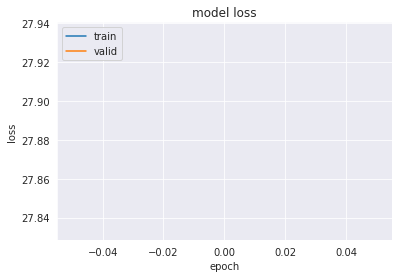

In [29]:
#%autoreload 2
(history_list, 

#scores_valid_list,
scores_test_list, 

#function_values_valid_list, 
function_values_test_list, 

#polynomial_dict_valid_list,
polynomial_dict_test_list,

#distrib_dict_valid_list,
distrib_dict_test_list,

model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

## Evaluate Interpretation Net

In [30]:
polynomial_true_monomial_list = tf.constant([0,2,2,1,2,1])

In [31]:
polynomial_true_monomial_list = tf.map_fn(fn=lambda x: tf.sparse.to_dense(tf.SparseTensor([[x]], [1], [d+1])), elems=polynomial_true_monomial_list, fn_output_signature=tf.TensorSpec([d+1], dtype=tf.int32))
polynomial_true_monomial_list




<tf.Tensor: shape=(6, 3), dtype=int32, numpy=
array([[1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0]], dtype=int32)>

In [32]:
t1=tf.sparse.to_dense(tf.SparseTensor([[1]], [1], [d+1]))
t1

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 1, 0], dtype=int32)>

In [33]:
polynomial_dict_test_list[-1].keys()

dict_keys(['lstsq_lambda_pred_polynomials', 'lstsq_target_polynomials', 'target_polynomials', 'inet_polynomials', 'symbolic_regression_functions'])

In [34]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [35]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 176)]        0                                            
__________________________________________________________________________________________________
hidden1_512 (Dense)             (None, 512)          90624       input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 512)          0           hidden1_512[0][0]                
__________________________________________________________________________________________________
dropout1_0.25 (Dropout)         (None, 512)          0           activation1_relu[0][0]           
______________________________________________________________________________________________

In [36]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [37]:
scores_test_list[-1]

MAE  RMSE   MAPE  \
lambda_preds_VS_target_polynomials                   NaN   NaN    NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials        NaN   NaN    NaN   
lambda_preds_VS_lstsq_target_polynomials             NaN   NaN    NaN   
lambda_preds_VS_inet_polynomials                     NaN   NaN    NaN   
lambda_preds_VS_symbolic_regression_functions        NaN   NaN    NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.014 0.019  0.914   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000  0.000   
target_polynomials_VS_inet_polynomials             0.175 0.309  6.103   
target_polynomials_VS_symbolic_regression_funct...   NaN   NaN    NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.014 0.019 17.204   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.171 0.298 13.879   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...   NaN   NaN    NaN   
lstsq_target_polynomials_VS_inet_polynomials       0.175 0.309  6.103   
lstsq_target_polynomials_VS_symbolic_regression...   NaN   NaN    NaN   
inet_polynomials_VS_symbolic_regression_functions    NaN   NaN    NaN   

                                                    Accuracy  \
lambda_preds_VS_target_polynomials                       NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials            NaN   
lambda_preds_VS_lstsq_target_polynomials                 NaN   
lambda_preds_VS_inet_polynomials                         NaN   
lambda_preds_VS_symbolic_regression_functions            NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...     0.933   
target_polynomials_VS_lstsq_target_polynomials         1.000   
target_polynomials_VS_inet_polynomials                 0.300   
target_polynomials_VS_symbolic_regression_funct...       NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...     0.933   
lstsq_lambda_pred_polynomials_VS_inet_polynomials      0.300   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...       NaN   
lstsq_target_polynomials_VS_inet_polynomials           0.300   
lstsq_target_polynomials_VS_symbolic_regression...       NaN   
inet_polynomials_VS_symbolic_regression_functions        NaN   

                                                    Accuracy Multilabel  \
lambda_preds_VS_target_polynomials                                  NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials                       NaN   
lambda_preds_VS_lstsq_target_polynomials                            NaN   
lambda_preds_VS_inet_polynomials                                    NaN   
lambda_preds_VS_symbolic_regression_functions                       NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...                0.300   
target_polynomials_VS_lstsq_target_polynomials                    1.000   
target_polynomials_VS_inet_polynomials                            0.000   
target_polynomials_VS_symbolic_regression_funct...                  NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...                0.300   
lstsq_lambda_pred_polynomials_VS_inet_polynomials                 0.000   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...                  NaN   
lstsq_target_polynomials_VS_inet_polynomials                      0.000   
lstsq_target_polynomials_VS_symbolic_regression...                  NaN   
inet_polynomials_VS_symbolic_regression_functions                   NaN   

                                                    MAE FV  RMSE FV  MAPE FV  \
lambda_preds_VS_target_polynomials                   0.009    0.013    0.135   
lambda_preds_VS_lstsq_lambda_pred_polynomials        0.009    0.012    0.149   
lambda_preds_VS_lstsq_target_polynomials             0.009    0.013    0.135   
lambda_preds_VS_inet_polynomials                     0.459    0.536    1.334   
lambda_preds_VS_symbolic_regression_functions        0.124    0.161    1.247   
target_polynomials_VS_lstsq_lambda_pred_polynom...   0.004    0.005    0.083   
target_polynomials_VS_lstsq_target_polynomials       0.000    0.000    0.000   
target_polynomials

In [38]:
distrib_dict_test_list[-1]['MAE']

L-0   L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.012 0.012 0.020 0.010   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.012 0.012 0.019 0.010   
lambda_preds_VS_lstsq_target_polynomials           0.012 0.012 0.020 0.010   
lambda_preds_VS_inet_polynomials                   0.299 0.240 0.305 0.394   
lambda_preds_VS_symbolic_regression_functions      0.136 0.116 0.151 0.114   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.005 0.004 0.008 0.004   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.298 0.241 0.306 0.395   
target_polynomials_VS_symbolic_regression_funct... 0.137 0.116 0.150 0.113   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.005 0.004 0.008 0.004   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.299 0.239 0.305 0.393   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.134 0.115 0.148 0.112   
lstsq_target_polynomials_VS_inet_polynomials       0.298 0.241 0.306 0.395   
lstsq_target_polynomials_VS_symbolic_regression... 0.137 0.116 0.150 0.113   
inet_polynomials_VS_symbolic_regression_functions  0.341 0.185 0.335 0.368   

                                                     L-4   L-5   L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.010 0.006 0.006 0.009   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.010 0.006 0.005 0.009   
lambda_preds_VS_lstsq_target_polynomials           0.010 0.006 0.006 0.009   
lambda_preds_VS_inet_polynomials                   0.696 0.663 0.150 0.633   
lambda_preds_VS_symbolic_regression_functions      0.119 0.096 0.084 0.188   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.004 0.003 0.002 0.005   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.697 0.663 0.149 0.633   
target_polynomials_VS_symbolic_regression_funct... 0.120 0.097 0.083 0.188   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.004 0.003 0.002 0.005   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.696 0.664 0.149 0.633   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.118 0.096 0.083 0.187   
lstsq_target_polynomials_VS_inet_polynomials       0.697 0.663 0.149 0.633   
lstsq_target_polynomials_VS_symbolic_regression... 0.120 0.097 0.083 0.188   
inet_polynomials_VS_symbolic_regression_functions  0.723 0.689 0.119 0.571   

                                                     L-8   L-9  
lambda_preds_VS_target_polynomials                 0.005 0.006  
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.005 0.006  
lambda_preds_VS_lstsq_target_polynomials           0.005 0.006  
lambda_preds_VS_inet_polynomials                   0.632 0.581  
lambda_preds_VS_symbolic_regression_functions      0.161 0.076  
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.003 0.004  
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000  
target_polynomials_VS_inet_polynomials             0.632 0.583  
target_polynomials_VS_symbolic_regression_funct... 0.162 0.076  
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.003 0.004  
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.632 0.582  
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.162 0.076  
lstsq_target_polynomials_VS_inet_polynomials       0.632 0.583  
lstsq_target_polynomials_VS_symbolic_regression... 0.162 0.076  
inet_polynomials_VS_symbolic_regression_functions  0.583 0.573

In [39]:
distrib_dict_test_list[-1]['R2']

L-0     L-1      L-2  \
lambda_preds_VS_target_polynomials                    0.998   0.997    0.995   
lambda_preds_VS_lstsq_lambda_pred_polynomials         0.998   0.997    0.996   
lambda_preds_VS_lstsq_target_polynomials              0.998   0.997    0.995   
lambda_preds_VS_inet_polynomials                     -0.229  -0.126   -0.023   
lambda_preds_VS_symbolic_regression_functions         0.736   0.645    0.715   
target_polynomials_VS_lstsq_lambda_pred_polynom...    1.000   1.000    0.999   
target_polynomials_VS_lstsq_target_polynomials        1.000   1.000    1.000   
target_polynomials_VS_inet_polynomials               -0.222  -0.130   -0.025   
target_polynomials_VS_symbolic_regression_funct...    0.729   0.643    0.714   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...    1.000   1.000    0.999   
lstsq_lambda_pred_polynomials_VS_inet_polynomials    -0.226  -0.126   -0.024   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...    0.740   0.648    0.725   
lstsq_target_polynomials_VS_inet_polynomials         -0.222  -0.130   -0.025   
lstsq_target_polynomials_VS_symbolic_regression...    0.729   0.643    0.714   
inet_polynomials_VS_symbolic_regression_functions  -144.420 -32.254 -709.446   

                                                        L-3      L-4      L-5  \
lambda_preds_VS_target_polynomials                    0.999    0.998    1.000   
lambda_preds_VS_lstsq_lambda_pred_polynomials         0.999    0.998    1.000   
lambda_preds_VS_lstsq_target_polynomials              0.999    0.998    1.000   
lambda_preds_VS_inet_polynomials                     -1.002   -5.811   -2.573   
lambda_preds_VS_symbolic_regression_functions         0.833    0.721    0.900   
target_polynomials_VS_lstsq_lambda_pred_polynom...    1.000    1.000    1.000   
target_polynomials_VS_lstsq_target_polynomials        1.000    1.000    1.000   
target_polynomials_VS_inet_polynomials               -1.001   -5.747   -2.551   
target_polynomials_VS_symbolic_regression_funct...    0.833    0.721    0.899   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...    1.000    1.000    1.000   
lstsq_lambda_pred_polynomials_VS_inet_polynomials    -1.004   -5.878   -2.581   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...    0.836    0.723    0.901   
lstsq_target_polynomials_VS_inet_polynomials         -1.001   -5.747   -2.551   
lstsq_target_polynomials_VS_symbolic_regression...    0.833    0.721    0.899   
inet_polynomials_VS_symbolic_regression_functions  -123.896 -820.856 -303.380   

                                                       L-6      L-7      L-8  \
lambda_preds_VS_target_polynomials                   0.998    0.999    0.999   
lambda_preds_VS_lstsq_lambda_pred_polynomials        0.998    0.999    0.999   
lambda_preds_VS_lstsq_target_polynomials             0.998    0.999    0.999   
lambda_preds_VS_inet_polynomials                    -0.197   -1.684   -7.681   
lambda_preds_VS_symbolic_regression_functions        0.604    0.736    0.198   
target_polynomials_VS_lstsq_lambda_pred_polynom...   1.000    1.000    1.000   
target_polynomials_VS_lstsq_target_polynomials       1.000    1.000    1.000   
target_polynomials_VS_inet_polynomials              -0.199   -1.672   -7.600   
target_polynomials_VS_symbolic_regression_funct...   0.603    0.736    0.200   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...   1.000    1.000    1.000   
lstsq_lambda_pred_polynomials_VS_inet_polynomials   -0.196   -1.685   -7.654   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...   0.608    0.738    0.199   
lstsq_target_polynomials_VS_inet_polynomials        -0.199   -1.672   -7.600   
lstsq_target_polynomials_VS_symbolic_regression...   0.603    0.736    0.200   
inet_polynomials_VS_symbolic_regression_functions  -24.873 -779.883 -413.430   

                                                        L-9  
lambda_preds_VS_target_polynomials                    0.999  
lambda_preds_VS_lstsq_lambda_pred_polynomials         0.999  
lambda_pred

In [40]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']))

print(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.99582252598625


-0.774511415673697*a**2 + 0.0061562408480277*a*b + 0.0097885368502908*a*c - 0.2815972939211*a*d + 0.0104526883491679*a*e - 0.0638711788524916*a - 0.0082227661943231*b**2 - 0.0122339681659341*b*c - 0.0177970002280731*b*d - 0.0068693587313959*b*e + 0.0276196096107169*b + 0.743616817103639*c**2 + 0.0059657292306094*c*d - 0.302646547791261*c*e + 0.0532953588586103*c - 0.0177188217164428*d**2 + 0.859320024037959*d*e + 0.043192811693002*d - 0.0412031991595726*e**2 + 0.0594742782845718*e - 0.0230323248239322

In [41]:
r2_values_inet = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: -2.2663674397155344 (10 Samples)
Mean (only positive): nan (0 Samples)


In [42]:
r2_values_lstsq_lambda = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.9983582245134157 (10 Samples)
Mean (only positive): 0.9983582245134157 (10 Samples)


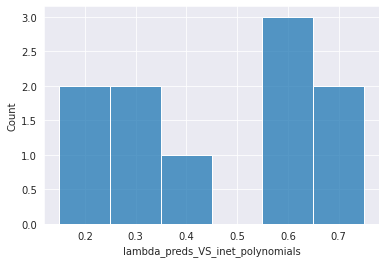

In [43]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

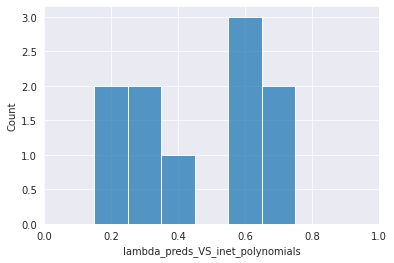

In [44]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


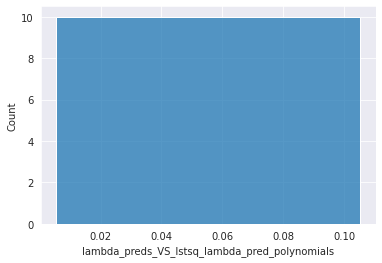

In [45]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

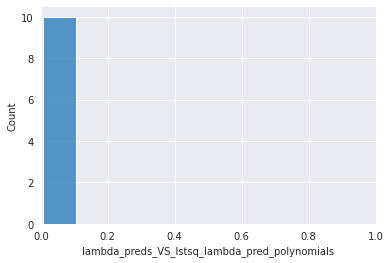

In [46]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


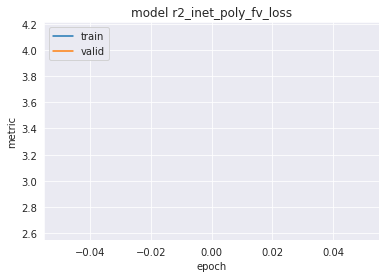

In [47]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


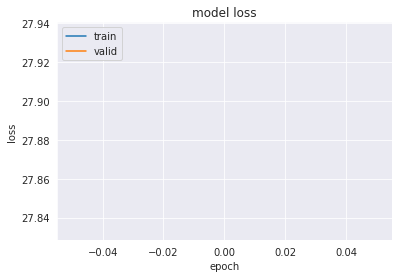

In [48]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [49]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [50]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [51]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [52]:
index = 6

custom_representation_keys_fixed = ['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(key)
    if key in custom_representation_keys_fixed:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
    elif key in custom_representation_keys_dynamic:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
    else:
        display(polynomial_dict_test_list[-1][key][index])

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_lambda_pred_polynomials


0.1567*a**2 - 0.0027*a*b + 0.007*a*c - 0.0025*a*d + 0.0006*a*e + 0.0153*a - 0.5737*b**2 + 0.2905*b*c + 0.0022*b*d - 0.0057*b*e - 0.0044*b - 0.0112*c**2 - 0.004*c*d + 0.007*c*e + 0.0459*c + 0.1857*d**2 - 0.0041*d*e + 0.0244*d - 0.0067*e**2 + 0.0039*e - 0.0069

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_target_polynomials


0.1753*a**2 - 0.5818*b**2 + 0.2941*b*c + 0.0364*c + 0.2068*d**2

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
target_polynomials


0.1753*a**2 - 0.5818*b**2 + 0.2941*b*c + 0.0364*c + 0.2068*d**2

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
inet_polynomials


0.00789999961853027*b*c - 0.047800000756979*b - 0.0130000002682209*c**2 - 0.164800003170967*d - 0.107400000095367

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
symbolic_regression_functions


-0.318*X1 + 0.318*X3

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


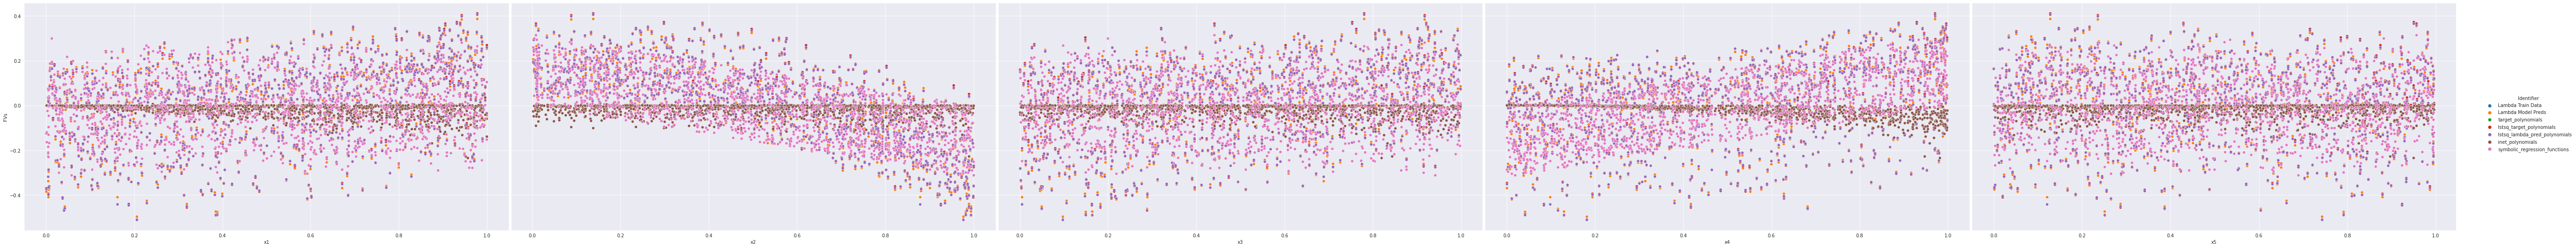

In [53]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

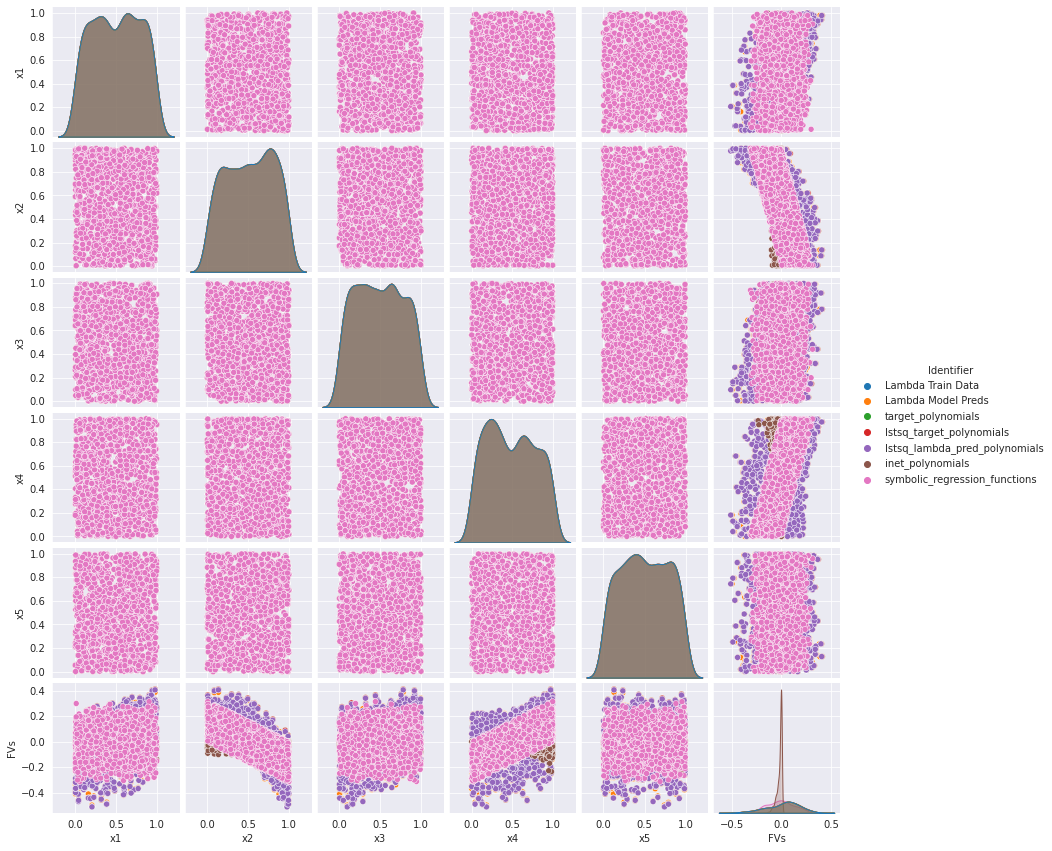

In [54]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

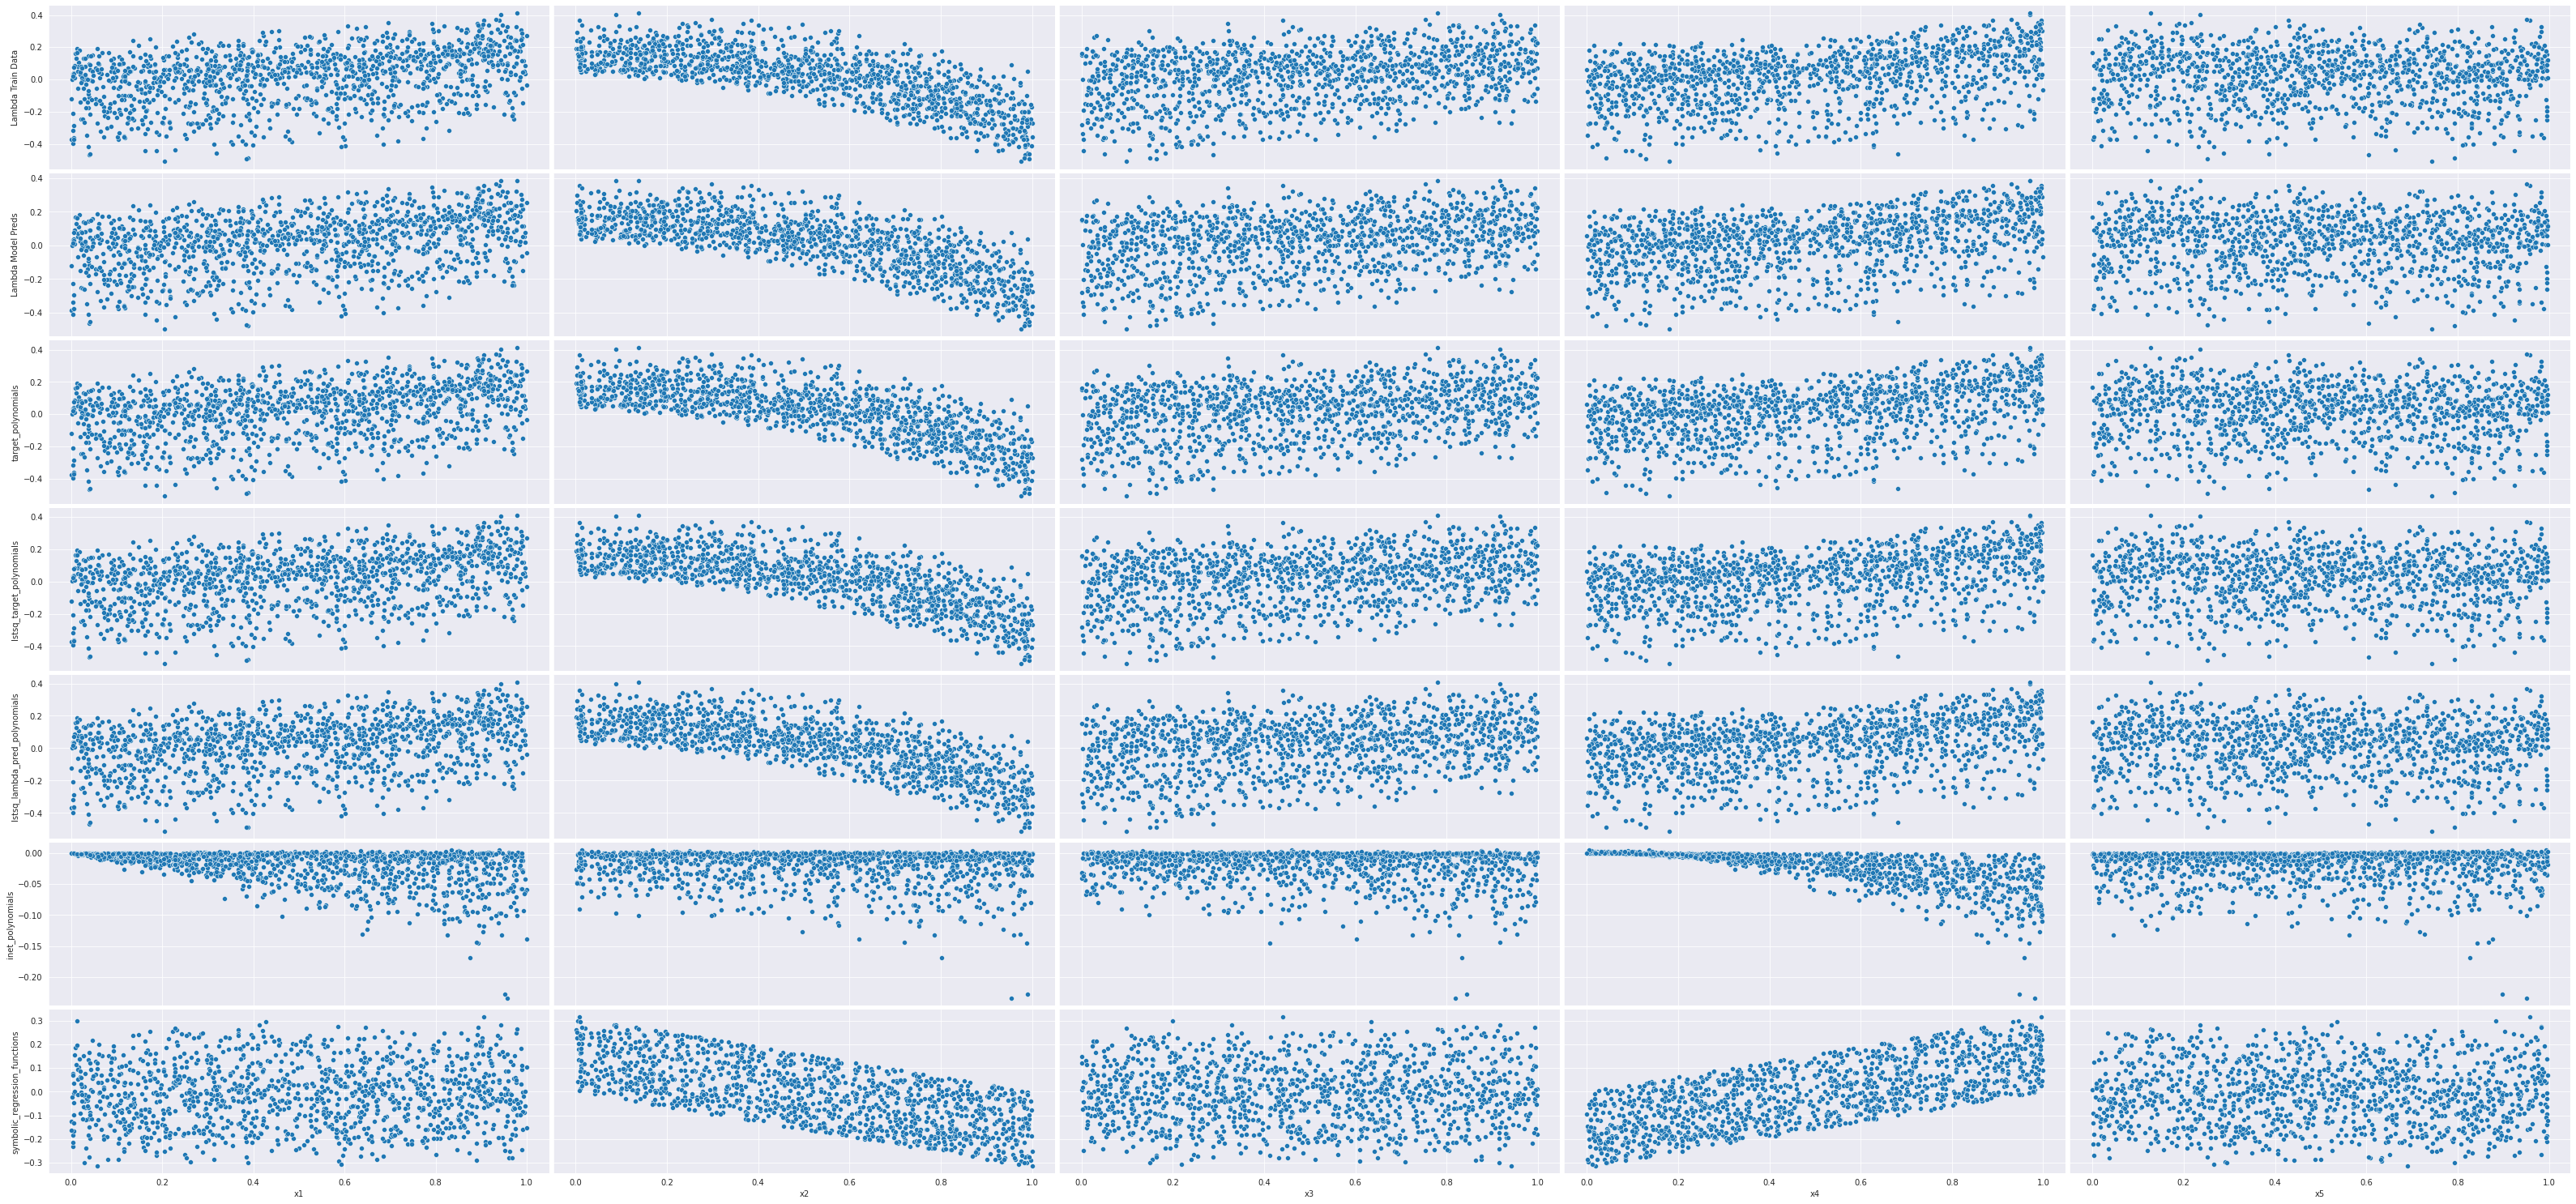

In [55]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [56]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [57]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

True
True


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


In [58]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 5.1003


In [59]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 8.5962


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [60]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

True


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


In [61]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 0.4225


In [62]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [63]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


NEW


ValueError: in user code:

    ../utilities/utility_functions.py:1332 function_to_optimize  *
        poly_optimize_identifiers_list = tf.keras.backend.flatten(poly_optimize_identifiers_list)
    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper  **
        return target(*args, **kwargs)
    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:3338 flatten
        return array_ops.reshape(x, [-1])
    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py:195 reshape
        result = gen_array_ops.reshape(tensor, shape, name)
    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/ops/gen_array_ops.py:8377 reshape
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:538 _apply_op_helper
        raise ValueError(

    ValueError: Tried to convert 'tensor' to a tensor and failed. Error: Dimension 0 in both shapes must be equal, but are 15 and 0. Shapes are [15] and [0].
    	From merging shape 21 with other shapes. for '{{node Reshape/packed}} = Pack[N=25, T=DT_FLOAT, axis=0](Softmax, Softmax_1, Softmax_2, Softmax_3, Softmax_4, Softmax_5, Softmax_6, Softmax_7, Softmax_8, Softmax_9, Softmax_10, Softmax_11, Softmax_12, Softmax_13, Softmax_14, Softmax_15, Softmax_16, Softmax_17, Softmax_18, Softmax_19, Softmax_20, Softmax_21, Softmax_22, Softmax_23, Softmax_24)' with input shapes: [0], [15], [30], [45], [60], [0], [15], [30], [30], [15], [0], [15], [15], [0], [0], [0], [15], [0], [0], [0], [0], [15], [0], [0], [0].


# Evaluate Real Dataset


##  Auto MPG-Dataset

In [ ]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())

#labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == features_autoMPG_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[RANDOM_SEED], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

In [ ]:
if interpretation_possible_autoMPG and n==1:
    x = tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [ ]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    #interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    interpretation_net_poly = make_inet_prediction(interpretation_net, weights_flat_autoMPG, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    variable_names = ['X' + str(i) for i in range(n)]
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x, variable_names=variable_names)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG and True:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')
    display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
if interpretation_possible_autoMPG and n==1:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    ax.set_ylim([0,50])
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])

current_seed = 42

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y*1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y+1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:


model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights #[weights/10 for weights in model_2_weights]


model_2_normalized_weights[-6] = model_2_normalized_weights[-6]/10
model_2_normalized_weights[-5] = model_2_normalized_weights[-5]/10

model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/100

model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

model_2.set_weights(model_2_normalized_weights)

print(model_2.get_weights())
print(model_2.predict([1, 10]))

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()